In [142]:
#load up modules

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

<center><font size="+2">Importing and inspecting the data</font></center>

In [73]:
#import data from csv into DF

train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')

In [74]:
#inspecting the data

train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [75]:
#looking at distribution of the data

train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000206AC6A48E0>,
      dtype=object)

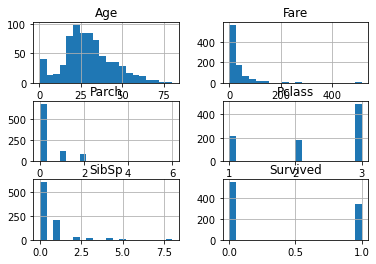

In [76]:
train.hist(bins=20)

In [78]:
train.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [79]:
#dropping the 2 embarked NA and substituting in average age for age NAs

train = train[train['Embarked'].notna()]
train['Age'] = train['Age'].fillna(29.7)

In [80]:
train.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      0
dtype: int64

In [81]:
#looking at correlations

train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.335549,-0.074675,-0.034040,0.083151,0.255290
Pclass,-0.335549,1.000000,-0.327949,0.081656,0.016824,-0.548193
Age,-0.074675,-0.327949,1.000000,-0.231875,-0.178235,0.088602
SibSp,-0.034040,0.081656,-0.231875,1.000000,0.414542,0.160887
Parch,0.083151,0.016824,-0.178235,0.414542,1.000000,0.217532
Fare,0.255290,-0.548193,0.088602,0.160887,0.217532,1.000000


<center><font size="+2">Preparing the data for the models</font></center>

In [82]:
#dropping name, ticket, cabin columns since they aren't predictors
#dropping SibSp and Parch because of low correlation with survived
#also dropping fare since it is correlated with Pclass and Pclass has a higher correlation with survived

train_prep = train.drop(columns=['Name','Ticket','Cabin','SibSp','Parch','Fare'], axis=1)

In [83]:
train_prep.head()

,Survived,Pclass,Sex,Age,Embarked
PassengerId,,,,,
1,0,3,male,22.0,S
2,1,1,female,38.0,C
3,1,3,female,26.0,S
4,1,1,female,35.0,S
5,0,3,male,35.0,S


In [84]:
#Transforming Pclass into three class categories, Upper, Middle, Lower and dropping Pclass column

conditions = [
    (train_prep['Pclass'] == 1),
    (train_prep['Pclass'] == 2),
    (train_prep['Pclass'] == 3)
    ]

values = ['Upper','Middle','Lower']

train_prep['Class'] = np.select(conditions, values)
train_prep = train_prep.drop(columns=['Pclass'], axis=1)

In [85]:
train_prep.head()

,Survived,Sex,Age,Embarked,Class
PassengerId,,,,,
2,1,female,38.0,C,Upper
3,1,female,26.0,S,Lower
4,1,female,35.0,S,Upper
5,0,male,35.0,S,Lower
6,0,male,29.7,Q,Lower


In [86]:
#preparing categorical data for encoding

cat_train = ('Sex','Embarked','Class')

enc = OneHotEncoder()
hot_matrix_train = []
hot_df_train = pd.DataFrame()

for column in train_prep:
    if column in cat_train:
        hot_matrix_train = enc.fit_transform(train_prep[[column]]).toarray()
        df = pd.DataFrame(hot_matrix_train, columns=enc.get_feature_names([column]))
        hot_df_train = pd.concat([hot_df_train,df], axis=1)

In [87]:
#dropping category columns, adding in encoded sparse matrix

train_hot = train_prep.drop(columns = ['Sex','Embarked','Class'], axis=1)
train_hot.reset_index(drop=True, inplace=True)
hot_df_train.reset_index(drop=True, inplace=True)
train_hot_ready = pd.concat([train_hot,hot_df_train], axis=1)

In [88]:
train_hot_ready.head()

,Survived,Age,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Class_Lower,Class_Middle,Class_Upper
0,1,38.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,26.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1,35.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0,35.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0,29.7,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


<center><font size="+2">Fitting data into models</font></center>

In [91]:
#splitting out predictors and labels

x = train_hot_ready.drop(columns = ['Survived'], axis=1)
y = train_hot_ready['Survived']

In [143]:
#fitting multiple models before comparing accuracy of each

sgd_clf = SGDClassifier (random_state=42)
gnb = GaussianNB()
log_reg = LogisticRegression(max_iter=1000)
forest_clf = RandomForestClassifier(random_state=42)

sgd_clf.fit(x, y)
gnb.fit(x, y)
log_reg.fit(x, y)
forest_clf.fit(x, y)

SGDClassifier(random_state=42)

GaussianNB()

LogisticRegression(max_iter=1000)

RandomForestClassifier(random_state=42)

In [144]:
#SGD, Naive Bayes, Log classifier CV 5 folds

sgd_pred = cross_val_predict(sgd_clf, x, y, cv=5)
gnb_pred = cross_val_predict(gnb, x, y, cv=5)
log_pred = cross_val_predict(log_reg, x, y, cv=5)
forest_pred = cross_val_predict(forest_clf, x, y, cv=5)

sgd_scores = cross_val_predict(sgd_clf, x, y, cv=5, method="decision_function")
gnb_scores = cross_val_predict(gnb, x, y, cv=5, method="predict_proba")
log_scores = cross_val_predict(log_reg, x, y, cv=5, method="predict_proba")
forest_scores = cross_val_predict(forest_clf, x, y, cv=5, method="predict_proba")

In [116]:
#SGD Confusion Matrix, precision, recall, and f1

confusion_matrix(y, sgd_pred)
print('Precision: ',precision_score(y, sgd_pred))
print('Recall: ', recall_score(y, sgd_pred))
print('F1 Score: ', f1_score(y, sgd_pred))

array([[427, 121],
       [116, 224]], dtype=int64)

Precision:  0.6492753623188405
Recall:  0.6588235294117647
F1 Score:  0.654014598540146


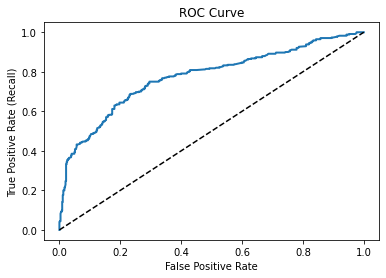

In [129]:
fpr, tpr, thresholds = roc_curve(y, sgd_scores)

#defining function to plot ROC graphs

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    

plot_roc_curve(fpr, tpr)
plt.show()

In [117]:
#Naive Bayes Confusion Matrix, precision, recall, and f1

confusion_matrix(y, gnb_pred)
print('Precision: ',precision_score(y, gnb_pred))
print('Recall: ', recall_score(y, gnb_pred))
print('F1 Score: ', f1_score(y, gnb_pred))

array([[437, 111],
       [ 91, 249]], dtype=int64)

Precision:  0.6916666666666667
Recall:  0.7323529411764705
F1 Score:  0.7114285714285714


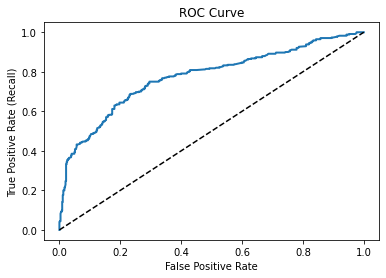

In [130]:
y_gnb_scores = gnb_scores[:,1]

fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y, y_gnb_scores)

plot_roc_curve(fpr_gnb, tpr_gnb)
plt.show()

In [118]:
#Log Confusion Matrix, precision, recall, and f1

confusion_matrix(y, log_pred)
print('Precision: ',precision_score(y, log_pred))
print('Recall: ', recall_score(y, log_pred))
print('F1 Score: ', f1_score(y, log_pred))

array([[467,  81],
       [105, 235]], dtype=int64)

Precision:  0.7436708860759493
Recall:  0.6911764705882353
F1 Score:  0.7164634146341462


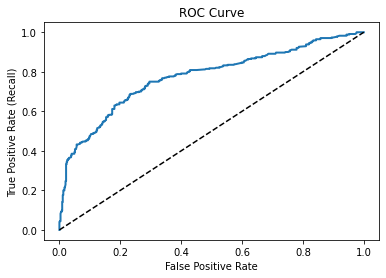

In [131]:
y_log_scores = log_scores[:,1]

fpr_log, tpr_log, thresholds_log = roc_curve(y, y_log_scores)

plot_roc_curve(fpr_log, tpr_log)
plt.show()

In [145]:
#Random Forest Confusion Matrix, precision, recall, and f1

confusion_matrix(y, forest_pred)
print('Precision: ',precision_score(y, forest_pred))
print('Recall: ', recall_score(y, forest_pred))
print('F1 Score: ', f1_score(y, forest_pred))

array([[471,  77],
       [102, 238]], dtype=int64)

Precision:  0.7555555555555555
Recall:  0.7
F1 Score:  0.7267175572519083


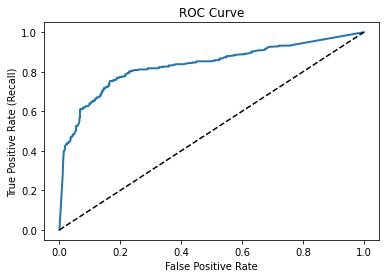

In [146]:
y_forest_scores = forest_scores[:,1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y, y_forest_scores)

plot_roc_curve(fpr_forest, tpr_forest)
plt.show()

<Figure size 1440x1440 with 0 Axes>

(0.0, 1.0)

(0.0, 1.0)

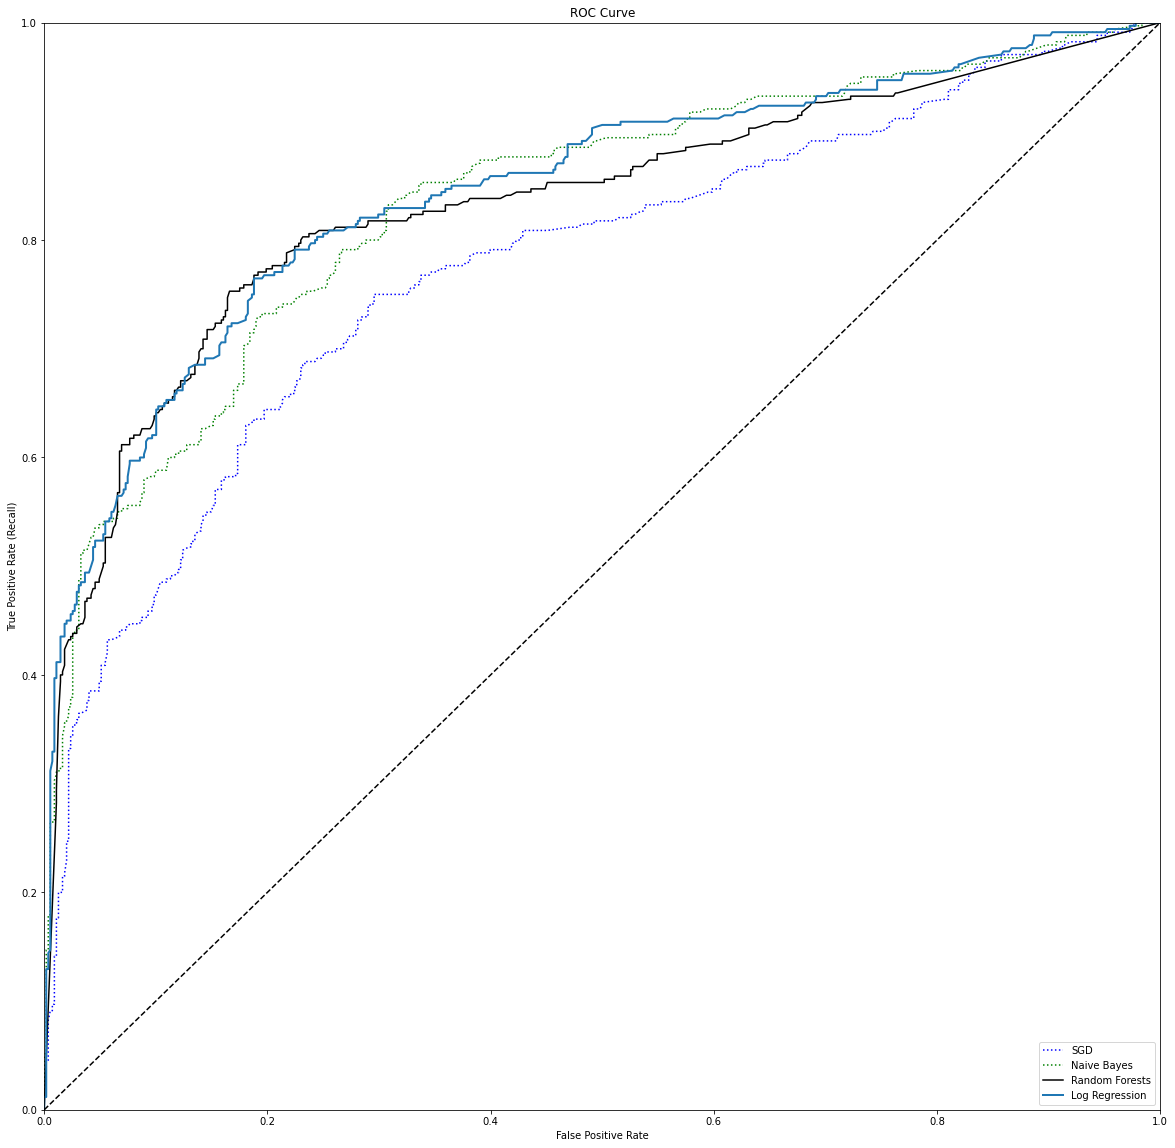

In [150]:
#plotting the ROC curves against each other

plt.figure(figsize=(20,20))
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_gnb, tpr_gnb, "g:", label="Naive Bayes")
plt.plot(fpr_forest, tpr_forest, "k-", label="Random Forests")
plot_roc_curve(fpr_log, tpr_log, "Log Regression")
plt.legend(loc="lower right")
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [151]:
#comparing AUC scores of the three

print("The ROC AUC score of SGD is: ", roc_auc_score(y, sgd_scores))
print("The ROC AUC score of Naive Bayes is: ", roc_auc_score(y, y_gnb_scores))
print("The ROC AUC score of Log Regression is: ", roc_auc_score(y, y_log_scores))
print("The ROC AUC score of Random Forest is: ", roc_auc_score(y, y_forest_scores))

The ROC AUC score of SGD is:  0.7736233361957923
The ROC AUC score of Naive Bayes is:  0.8349157363675397
The ROC AUC score of Log Regression is:  0.8448770931730357
The ROC AUC score of Random Forest is:  0.8329862601975097


<center><font size="+2">Transforming test data to be ready</font></center>

In [152]:
test.isna().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [153]:
#filling in NA ages with same number as training data and the average fare from the training data
test['Age'] = test['Age'].fillna(29.7)
test['Fare'] = test['Fare'].fillna(32.2)

In [154]:
test.isna().sum()

Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       327
Embarked      0
dtype: int64

In [155]:
#performing same data transformation as the training data

test_prep = test.drop(columns=['Name','Ticket','Cabin','SibSp','Parch','Fare'], axis=1)

In [156]:
test_prep.head()

,Pclass,Sex,Age,Embarked
PassengerId,,,,
892,3,male,34.5,Q
893,3,female,47.0,S
894,2,male,62.0,Q
895,3,male,27.0,S
896,3,female,22.0,S


In [158]:
#Transforming Pclass into three class categories, Upper, Middle, Lower and dropping Pclass column

conditions = [
    (test_prep['Pclass'] == 1),
    (test_prep['Pclass'] == 2),
    (test_prep['Pclass'] == 3)
    ]

values = ['Upper','Middle','Lower']

test_prep['Class'] = np.select(conditions, values)
test_prep = test_prep.drop(columns=['Pclass'], axis=1)

In [159]:
test_prep.head()

,Sex,Age,Embarked,Class
PassengerId,,,,
892,male,34.5,Q,Lower
893,female,47.0,S,Lower
894,male,62.0,Q,Middle
895,male,27.0,S,Lower
896,female,22.0,S,Lower


In [160]:
#preparing categorical data for encoding

cat_train = ('Sex','Embarked','Class')

enc = OneHotEncoder()
hot_matrix_test = []
hot_df_test = pd.DataFrame()

for column in test_prep:
    if column in cat_train:
        hot_matrix_test = enc.fit_transform(test_prep[[column]]).toarray()
        df = pd.DataFrame(hot_matrix_test, columns=enc.get_feature_names([column]))
        hot_df_test = pd.concat([hot_df_test,df], axis=1)

In [161]:
#dropping category columns, adding in encoded sparse matrix

test_hot = test_prep.drop(columns = ['Sex','Embarked','Class'], axis=1)
test_hot.reset_index(drop=True, inplace=True)
hot_df_test.reset_index(drop=True, inplace=True)
test_hot_ready = pd.concat([test_hot,hot_df_test], axis=1)

In [162]:
test_hot_ready.head()

,Age,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Class_Lower,Class_Middle,Class_Upper
0,34.5,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,47.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,62.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,27.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,22.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [163]:
#using the models to predict outcome on test data

test_sgd = sgd_clf.predict(test_hot_ready)
test_gnb = gnb.predict(test_hot_ready)
test_log = log_reg.predict(test_hot_ready)
test_forest = forest_clf.predict(test_hot_ready)

In [168]:
df_sgd = pd.DataFrame(test_sgd)
df_gnb = pd.DataFrame(test_gnb)
df_log = pd.DataFrame(test_log)
df_forest = pd.DataFrame(test_forest)

df_sgd.to_csv('sgd approach.csv')
df_gnb.to_csv('gnb approach.csv')
df_log.to_csv('log approach.csv')
df_forest.to_csv('forest approach.csv')